In [151]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import math
from scipy.ndimage import gaussian_filter1d


subject_id = "007"
experiment_id = "003"
monitor_width_cm = 47.6
monitor_height_cm = 26.8
resolution = (1920, 1080)
viewer_distance_cm = 70.0
cm_per_pixel_x = monitor_width_cm / resolution[0]
cm_per_pixel_y = monitor_height_cm / resolution[1]
viewing_distance_cm = 70
diag_length_cm = math.sqrt(monitor_width_cm**2 + monitor_height_cm**2)



In [152]:
pose1_df = pd.read_csv(f"./exported_csv/pose_df/pose1_df_id{subject_id}-{experiment_id}.csv")

In [153]:
def prepare_pose_df(df):
    df = df.copy()
    df["gx_centered"] = df["mean_x"] - 0.5
    df["gy_centered"] = df["mean_y"] - 0.5
    df["x_cm"] = df["gx_centered"] * resolution[0] * cm_per_pixel_x
    df["y_cm"] = df["gy_centered"] * resolution[1] * cm_per_pixel_y
    df["x_deg"] = np.degrees(np.arctan2(df["x_cm"], viewer_distance_cm))
    df["y_deg"] = np.degrees(np.arctan2(df["y_cm"], viewer_distance_cm))
    df["epoch_sec"] = df["epoch_time"]
    df["valid"] = df["validity_sum"] == 2
    return df


In [154]:
def interpolate_norm(df, time_col="epoch_sec", max_gap_ms=100):
    df = df.copy()
    df["valid"] = df["validity_sum"] == 2
    df["interp_x"] = np.nan
    df["interp_y"] = np.nan
    df.loc[df["valid"], "interp_x"] = df.loc[df["valid"], "mean_x"]
    df.loc[df["valid"], "interp_y"] = df.loc[df["valid"], "mean_y"]
    df["interp_x"] = df["interp_x"].interpolate(limit_area="inside")
    df["interp_y"] = df["interp_y"].interpolate(limit_area="inside")

    invalid_mask = ~df["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = df[invalid_mask].groupby(group_id)
    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start)*1000
        if duration_ms > max_gap_ms:
            df.loc[block.index, ["interp_x", "interp_y"]] = np.nan
    return df


In [155]:
def filter_norm(df, sigma=1.0):
    df = df.copy()
    df["filtered_x"] = np.nan
    df["filtered_y"] = np.nan
    valid_mask = df["interp_x"].notna() & df["interp_y"].notna()
    block_id = (valid_mask != valid_mask.shift()).cumsum()
    blocks = df[valid_mask].groupby(block_id)

    for _, block in blocks:
        idx = block.index
        smoothed_x = gaussian_filter1d(block["interp_x"], sigma=sigma)
        smoothed_y = gaussian_filter1d(block["interp_y"], sigma=sigma)
        df.loc[idx, "filtered_x"] = smoothed_x
        df.loc[idx, "filtered_y"] = smoothed_y
    return df




In [156]:
def detect_fixations_ivt(df, resolution=(1920,1080), viewer_distance_cm=70.0, monitor_width_cm=47.6):
    fixations = []
    timestamps = df["epoch_sec"].to_numpy()
    xs = df["filtered_x"].to_numpy()
    ys = df["filtered_y"].to_numpy()

    # 視野角換算用
    cm_per_pixel_x = monitor_width_cm / resolution[0]

    delta_t = np.diff(timestamps)
    delta_x = np.diff(xs)
    delta_y = np.diff(ys)
    safe_delta_t = np.where(delta_t==0, np.nan, delta_t)
    velocities = np.sqrt(delta_x**2 + delta_y**2) / safe_delta_t
    velocities = np.insert(velocities, 0, 0)
    velocities = np.nan_to_num(velocities)

    in_fixation = False
    start_idx = 0

    for i in range(len(df)):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            if in_fixation:
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i-1]
                duration = (t_end - t_start)*1000
                if duration >= 100:
                    x_mean_norm = np.mean(xs[start_idx:i])
                    y_mean_norm = np.mean(ys[start_idx:i])
                    x_mean_px = x_mean_norm * resolution[0]
                    y_mean_px = y_mean_norm * resolution[1]
                    x_cm = (x_mean_norm - 0.5)*resolution[0]*cm_per_pixel_x
                    y_cm = (y_mean_norm - 0.5)*resolution[1]*cm_per_pixel_x
                    x_deg = np.degrees(np.arctan2(x_cm, viewer_distance_cm))
                    y_deg = np.degrees(np.arctan2(y_cm, viewer_distance_cm))
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_norm": x_mean_norm,
                        "y_mean_norm": y_mean_norm,
                        "x_mean_px": x_mean_px,
                        "y_mean_px": y_mean_px,
                        "x_mean_deg": x_deg,
                        "y_mean_deg": y_deg,
                    })
            continue
        if velocities[i] < 100:
            if not in_fixation:
                in_fixation = True
                start_idx = i
        else:
            if in_fixation:
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i-1]
                duration = (t_end - t_start)*1000
                if duration >= 100:
                    x_mean_norm = np.mean(xs[start_idx:i])
                    y_mean_norm = np.mean(ys[start_idx:i])
                    x_mean_px = x_mean_norm * resolution[0]
                    y_mean_px = y_mean_norm * resolution[1]
                    x_cm = (x_mean_norm - 0.5)*resolution[0]*cm_per_pixel_x
                    y_cm = (y_mean_norm - 0.5)*resolution[1]*cm_per_pixel_x
                    x_deg = np.degrees(np.arctan2(x_cm, viewer_distance_cm))
                    y_deg = np.degrees(np.arctan2(y_cm, viewer_distance_cm))
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_norm": x_mean_norm,
                        "y_mean_norm": y_mean_norm,
                        "x_mean_px": x_mean_px,
                        "y_mean_px": y_mean_px,
                        "x_mean_deg": x_deg,
                        "y_mean_deg": y_deg,
                    })

    # 最後のfixation
    if in_fixation:
        t_start = timestamps[start_idx]
        t_end = timestamps[-1]
        duration = (t_end - t_start)*1000
        if duration >= 100:
            x_mean_norm = np.mean(xs[start_idx:])
            y_mean_norm = np.mean(ys[start_idx:])
            x_mean_px = x_mean_norm * resolution[0]
            y_mean_px = y_mean_norm * resolution[1]
            x_cm = (x_mean_norm - 0.5)*resolution[0]*cm_per_pixel_x
            y_cm = (y_mean_norm - 0.5)*resolution[1]*cm_per_pixel_x
            x_deg = np.degrees(np.arctan2(x_cm, viewer_distance_cm))
            y_deg = np.degrees(np.arctan2(y_cm, viewer_distance_cm))
            fixations.append({
                "start_time": t_start,
                "end_time": t_end,
                "duration_ms": duration,
                "x_mean_norm": x_mean_norm,
                "y_mean_norm": y_mean_norm,
                "x_mean_px": x_mean_px,
                "y_mean_px": y_mean_px,
                "x_mean_deg": x_deg,
                "y_mean_deg": y_deg,
            })

    return pd.DataFrame(fixations)


In [159]:
def process_pose_df_ivt(df):
    df_prepared = prepare_pose_df(df)
    df_interp = interpolate_norm(df_prepared)
    df_filtered = filter_norm(df_interp)
    fix_df = detect_fixations_ivt(df_filtered)
    return fix_df


In [160]:
fix_df = process_pose_df_ivt(pose1_df)
print(fix_df)
# fix_df.to_csv(f"./exported_csv/pose_df/pose_fix_df/pose_fix_df_id{subject_id}-{experiment_id}.csv", index=False)

      start_time      end_time  duration_ms  x_mean_norm  y_mean_norm  \
0   1.734326e+09  1.734326e+09   381.000042     0.493866     0.476209   
1   1.734326e+09  1.734326e+09  1562.999964     0.523561     0.471751   
2   1.734326e+09  1.734326e+09   966.000080     0.515746     0.483513   
3   1.734326e+09  1.734326e+09  4650.000095     0.500897     0.505330   
4   1.734326e+09  1.734326e+09  3052.000046     0.510179     0.503915   
5   1.734326e+09  1.734326e+09  2114.000082     0.506085     0.506980   
6   1.734326e+09  1.734326e+09  1107.999802     0.506024     0.508082   
7   1.734326e+09  1.734326e+09   983.000040     0.503590     0.502115   
8   1.734326e+09  1.734326e+09   599.999905     0.503672     0.506069   
9   1.734326e+09  1.734326e+09  1073.999882     0.507576     0.491755   
10  1.734326e+09  1.734326e+09   327.999830     0.513934     0.496971   
11  1.734326e+09  1.734326e+09  1441.999912     0.510867     0.493257   
12  1.734326e+09  1.734326e+09   404.000044     0.5

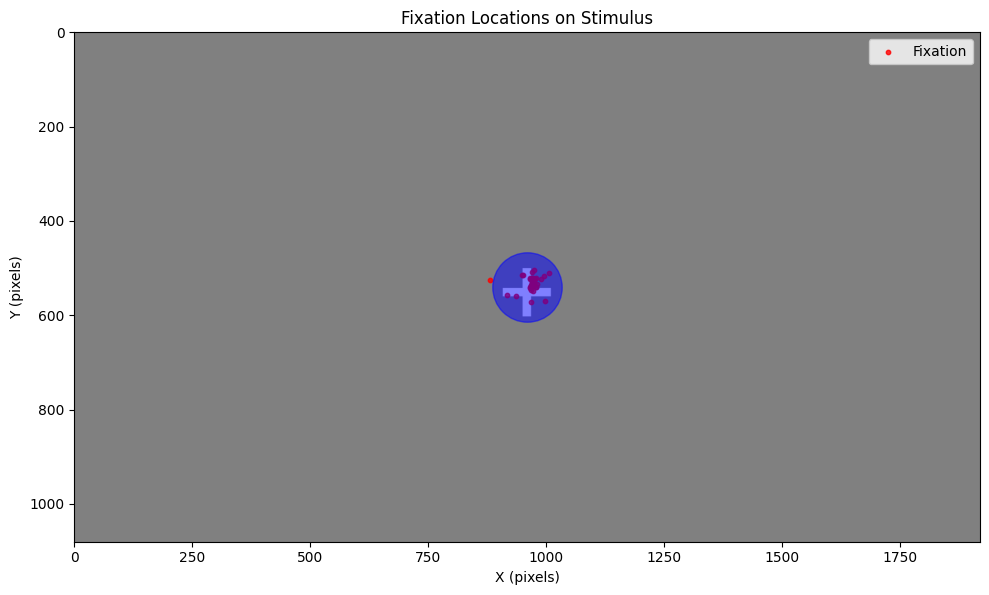

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# === 背景画像の読み込み ===

img = mpimg.imread("../koshiten.png")

# === 画面サイズ（ピクセル） ===
width_px, height_px = resolution

# === 注視点の座標を計算 ===
x_px = fix_df["x_mean_norm"] * width_px
y_px = fix_df["y_mean_norm"] * height_px

# === プロット ===
fig, ax = plt.subplots(figsize=(10, 6))

# 中心の座標
center_x = 1920 / 2
center_y = 1080 / 2
# 中心に点をプロット
ax.plot(center_x, center_y, 'bo', markersize=50,alpha=0.5)  # 'ro'は赤い点
# 背景画像
ax.imshow(img, extent=[0, width_px, height_px, 0])

# 注視点
ax.scatter(
    x_px,
    y_px,
    c="red",
    s=10,
    alpha=0.8,
    label="Fixation"
)

# 軸設定
ax.set_xlim(0, width_px)
ax.set_ylim(height_px, 0)
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.set_title("Fixation Locations on Stimulus")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
def evaluate_precision(df):
    total_len = len(df)
    
    # validity_sum == 2 のデータのみを使う
    valid_df = df.copy()
    
    valid_df = valid_df.dropna(subset=["x_mean_norm","y_mean_norm"])
    # データ行列
    # データ行列
    data = df[["x_mean_norm","y_mean_norm"]].values

    # データ数が少ない場合は処理しない
    if len(data) < 2:
        return {
            "error": "Not enough data points for covariance calculation."
        }


    # 重心
    center = np.mean(data, axis=0)

    # 共分散行列と逆行列
    cov = np.cov(data, rowvar=False)
    # 行列が特異かどうか
    if np.linalg.det(cov) == 0:
        return {
            "error": "Covariance matrix is singular (identical or collinear points)."
        }
    inv_cov = np.linalg.inv(cov)

    # 差分
    diff = data - center
    left = np.dot(diff, inv_cov)
    mahal_sq = np.sum(left * diff, axis=1)
    mahal_dist = np.sqrt(mahal_sq)

    # σ=1以内
    within_sigma1 = np.sum(mahal_dist <= 1)
    total_valid = len(mahal_dist)
    percent_sigma1 = 100 * within_sigma1 / total_valid

    # 平均マハラノビス距離
    mahal_mean = np.mean(mahal_dist)

    # ユークリッド距離も参考値で計算（正確度）
    euclid_dist = np.linalg.norm(diff, axis=1)
    euclid_mean = np.mean(euclid_dist)

    # ユークリッド距離→cm→視野角
    euclid_mean_cm = euclid_mean * diag_length_cm
    euclid_mean_deg = np.degrees(np.arctan(euclid_mean_cm / viewing_distance_cm))

    # 結果
    return {
        "subject_id": subject_id,
        "task_id": experiment_id,
        "pose_length": total_len,
        "center_x": center[0],
        "center_y": center[1],
        "mahalanobis_mean": mahal_mean,
        "percent_within_sigma1": percent_sigma1,
        "euclid_mean": euclid_mean,
        "euclid_mean_deg": euclid_mean_deg,
    }

In [ ]:
# def evaluate_accuracy(df, pose_name):
#     total_len = len(df)
    
#     # validity_sum == 2 のデータのみを使う
#     valid_df = df[df["validity_sum"] == 2].copy()

#     valid_df["mean_x"] = (valid_df["left_x"] + valid_df["right_x"]) / 2
#     valid_df["mean_y"] = (valid_df["left_y"] + valid_df["right_y"]) / 2
#     valid_df = valid_df.dropna(subset=["mean_x", "mean_y"])
#     if valid_df.empty:
#         raise ValueError("有効なデータがありません。")

#     # データ行列
#     data = valid_df[["mean_x", "mean_y"]].values

#     # 重心
#     center = np.mean(data, axis=0)

#     # 共分散行列と逆行列
#     cov = np.cov(data, rowvar=False)
#     inv_cov = np.linalg.inv(cov)

#     # 差分
#     diff = data - center
#     left = np.dot(diff, inv_cov)
#     mahal_sq = np.sum(left * diff, axis=1)
#     mahal_dist = np.sqrt(mahal_sq)

#     # σ=1以内
#     within_sigma1 = np.sum(mahal_dist <= 1)
#     total_valid = len(mahal_dist)
#     percent_sigma1 = 100 * within_sigma1 / total_valid

#     # 平均マハラノビス距離
#     mahal_mean = np.mean(mahal_dist)

#     # ユークリッド距離も参考値で計算（正確度）
#     euclid_dist = np.linalg.norm(diff, axis=1)
#     euclid_mean = np.mean(euclid_dist)

#     # ユークリッド距離→cm→視野角
#     euclid_mean_cm = euclid_mean * diag_length_cm
#     euclid_mean_deg = np.degrees(np.arctan(euclid_mean_cm / viewing_distance_cm))

#     # 結果
#     return {
#         "subject_id": subject_id,
#         "task_id": experiment_id,
#         "pose": pose_name,
#         "pose_length": total_len,
#         "valid_data_count": total_valid,
#         "center_x": center[0],
#         "center_y": center[1],
#         "mahalanobis_mean": mahal_mean,
#         "percent_within_sigma1": percent_sigma1,
#         "euclid_mean": euclid_mean,
#         "euclid_mean_deg": euclid_mean_deg,
#     }

In [ ]:
summary_list = []
summary_list.append(evaluate_precision(fix_df))

C:\Users\OWNER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [ ]:
summary_df = pd.DataFrame(summary_list)
summary_df

,subject_id,task_id,pose_length,center_x,center_y,mahalanobis_mean,percent_within_sigma1,euclid_mean,euclid_mean_deg
0,007,003,45,NaN,NaN,NaN,0.0,NaN,NaN
